Components for >=95% variance: 13



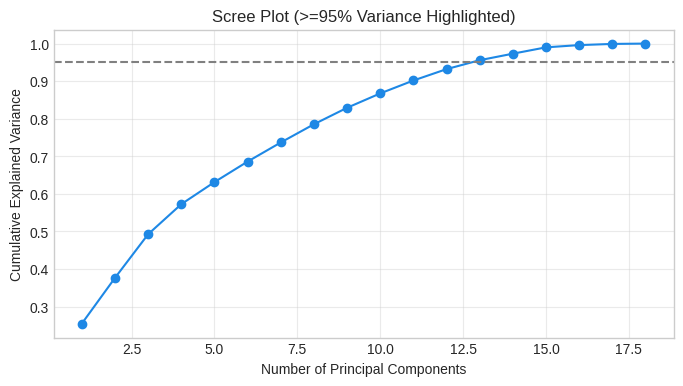

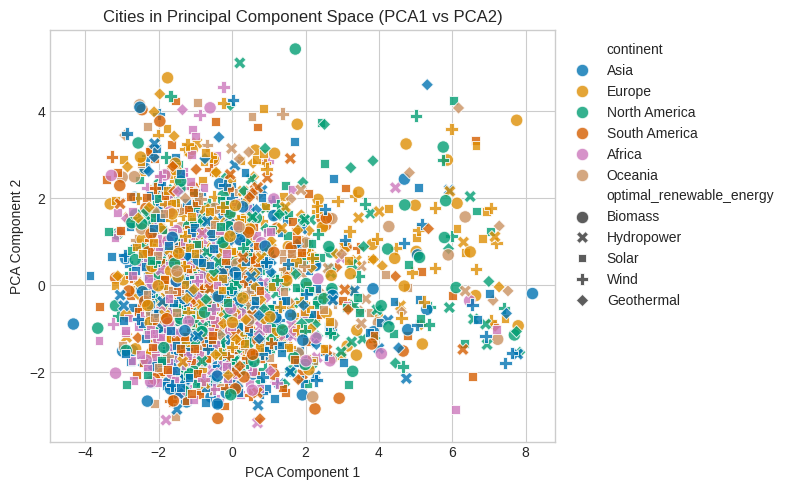

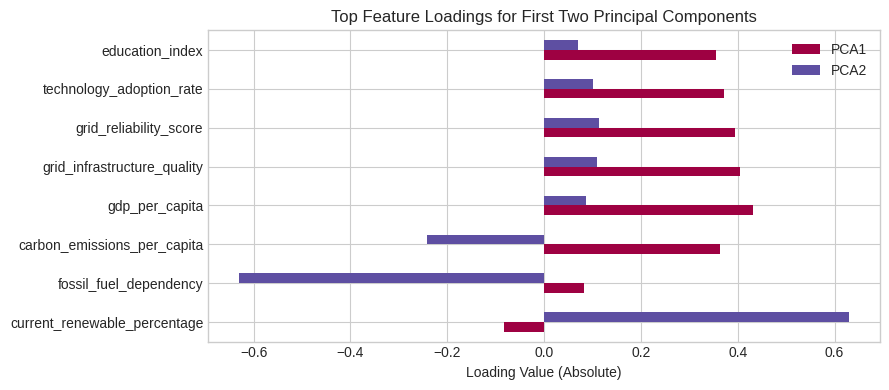

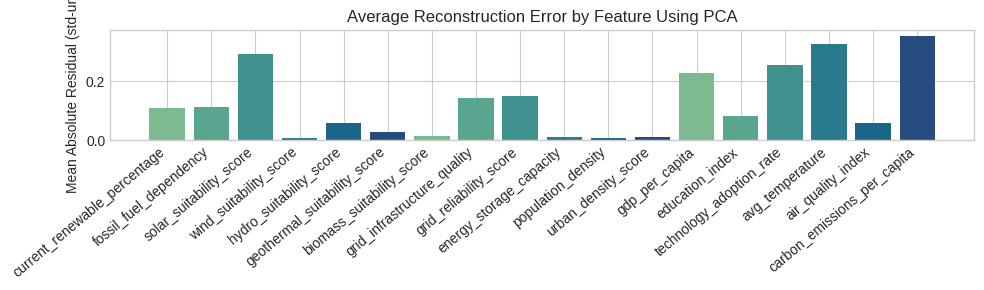

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load data
df = pd.read_csv('..//data//City_Optimized.csv')

# 1. Domain-driven Feature Selection
domain_features = [
    # Energy & Sustainability
    "current_renewable_percentage", "fossil_fuel_dependency",
    "solar_suitability_score", "wind_suitability_score", "hydro_suitability_score",
    "geothermal_suitability_score", "biomass_suitability_score",

    # Infrastructure quality/reliability
    "grid_infrastructure_quality", "grid_reliability_score", "energy_storage_capacity",

    # Socio-Economic & Urban
    "population_density", "urban_density_score", "gdp_per_capita", "education_index",
    "technology_adoption_rate",

    # Climate / Environmental
    "avg_temperature", "air_quality_index", "carbon_emissions_per_capita"
]
X_df = df[domain_features].copy().dropna()

# 2. Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X_df)

# 3. Fit PCA
pca = PCA()
pca.fit(X)
explained_var = np.cumsum(pca.explained_variance_ratio_)

n_components_90 = np.argmax(explained_var >= 0.95) + 1
print(f"Components for >=95% variance: {n_components_90}\n")

# 4. Scree Plot
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(explained_var)+1), explained_var, marker='o', color="#1e88e5")
plt.axhline(0.95, color='gray', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot (>=95% Variance Highlighted)')
plt.grid(alpha=0.4)
plt.show()

# 5. 2D PCA Scatter Plot
pca_2d = PCA(n_components=2)
X_pca2 = pca_2d.fit_transform(X)
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=X_pca2[:,0], y=X_pca2[:,1],
    hue=df.loc[X_df.index, "continent"], style=df.loc[X_df.index, "optimal_renewable_energy"],
    s=80, alpha=0.8)
plt.title('Cities in Principal Component Space (PCA1 vs PCA2)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(bbox_to_anchor=(1,1))
plt.tight_layout(); plt.show()

# 6. PCA Loadings Plot (Feature Contributions to PC1 & PC2)
loadings = pd.DataFrame(
    pca_2d.components_.T,
    columns=['PCA1', 'PCA2'],
    index=domain_features
)
loadings_abs = loadings.abs().sum(axis=1).sort_values(ascending=False)
top_features = loadings_abs.head(8).index

loadings.loc[top_features, ['PCA1','PCA2']].plot(
    kind='barh', figsize=(9,4), cmap='Spectral'
)
plt.title('Top Feature Loadings for First Two Principal Components')
plt.xlabel('Loading Value (Absolute)')
plt.tight_layout(); plt.show()

# 7. Optional: PCA Reconstruction Errors (on 90% var components)
pca_90 = PCA(n_components=n_components_90)
X_pca90 = pca_90.fit_transform(X)
X_approx = pca_90.inverse_transform(X_pca90)
errors = np.abs(X - X_approx)
mean_error_by_feature = errors.mean(axis=0)
plt.figure(figsize=(10,3))
plt.bar(domain_features, mean_error_by_feature, color=sns.color_palette('crest'))
plt.ylabel("Mean Absolute Residual (std-units)")
plt.xticks(rotation=40, ha='right')
plt.title("Average Reconstruction Error by Feature Using PCA")
plt.tight_layout(); plt.show()